In [476]:
from utils.database_connection import DatabaseConnection
import utils.results_repository as rep
import pandas as pd
import numpy as np
from utils.column_name_utils import *
import utils.query_utils as query
import matplotlib.pyplot as plot
import utils.dataframe_utils as df_util
import utils.path_utils as path_util
import utils.math_utils as math_util
import math
import utils.latex_utils as tex
from scipy import stats
import utils.time_series_utils as ts_util
import json
import utils.measurement_utils as m_util

In [477]:
db = DatabaseConnection()

Connected to MySQL Server version  8.0.32-24


In [478]:
measurements_used = 270
time_series_used = 1000
energy_per_time = 1000
generate_graphs = False

get_timeseries = True
get_measurements = False

In [479]:
# exp_name = "compiler"
exp_name = "measuring_instrument"
# exp_name = "app"
# exp_name = "run-many-times"
# exp_name = "cores"

In [480]:
used_dut_name = [
    'workstationtwo',
    # 'workstationone',
]

idle_case_config = -1

used_dut_name.sort()

used_dut_env = 'prod'

windows = "win32nt"
linux = "unix"

# used_os_names = [
#     windows, 
#     linux
# ]

used_test_case_names = [
    'fannkuch-redux.exe',
    'mandelbrot.exe',
    'idle-case.exe'
]

used_test_case_names.sort()

used_thread = [
    'multi-threaded'
]

used_thread.sort()

used_test_case_name = 'idle-case.exe'

ipg = "ipg"
lhm = "lhm"
rapl = "rapl"
clamp = "clamp"
plug = "plug"
scaphandre = "scaphandre"

windows_mi = [
    ipg, lhm, clamp, plug, scaphandre
]

linux_mi = [
    rapl, clamp, plug
]

used_mi_names = [
    clamp, ipg ##ipg, lhm, ipg, clamp, plug #, scaphandre, # plug, rapl
]

ipg_sample_rate = 100
lhm_sample_rate = 100
rapl_sample_rate = 100
clamp_sample_rate = 100
plug_sample_rate = 200
scaphandre_sample_rate = 100

used_min_temp = 0
used_max_temp = 200
used_burn_in = 1
used_allocated_cores = [
    []
]

used_allocated_cores.sort()

In [481]:
if exp_name == "compiler":
    experiment_name = "same-cpp-multi-core-micro-benchmark-different-compiler"
    experiment_number = 1
    
    used_os_names = [
        windows, 
    ]
    
    used_mi_names = [
        ipg
    ]
    
    used_compilers = [
        'clang', 'intel-one-api', 'min-gw', 'msvc'
    ]
    
    test_case_parameters = ["", "12", "16000"]

if exp_name == "measuring_instrument":
    experiment_name = "same-one-api-compiler-different-measuring-instruments-post-update-and-watt"
    experiment_number = 2
    
    used_os_names = [
        windows, 
        linux
    ]
    
    used_mi_names = [
        ipg, scaphandre, lhm, plug, rapl, clamp, rapl
        # clamp
        # ipg, clamp, plug, lhm, rapl #, lhm, scaphandre, # plug, rapl
        # lhm#, plug
        # lhm #clamp
        # rapl, plug
    ]
    
    used_compilers = [
        'intel-one-api'
    ]
    
    test_case_parameters = ["", "12", "64000"]
    
if exp_name == "run-many-times":
    experiment_name = "run-clamp-many-times-exp"
    experiment_number = 2
    
    used_os_names = [
        windows, 
    ]
    
    used_dut_name = [
        'workstationtwo',
    ]
    
    used_test_case_names = [
        'mandelbrot.exe',
    ]
    
    used_mi_names = [
        clamp
    ]
    
    used_compilers = [
        'intel-one-api'
    ]
    
    test_case_parameters = ["", "12", "64000"]

if exp_name == 'cores':
    experiment_name = "same-one-api-compiler-different-cores"
    experiment_number = 3
    
    used_os_names = [
        windows, 
    ]
    
    used_mi_names = [
        ipg #, clamp
    ]
    
    used_compilers = [
        'intel-one-api'
    ]
    
    used_test_case_names = [
        'nbody.exe',
        'spectral-norm.exe',
        'idle-case.exe'
    ]
    
    used_thread = [
        'single-threaded'
    ]
    
    used_allocated_cores = [
        ['0'], 
        ['1'], 
        ['2'],
        ['3'],
        ['4'],
        ['5'],
        ['6'],
        ['7'],
        ['8'],
        ['9'],
    ]
    
    used_os_names = [
        windows
    ]   
    
    test_case_parameters = ["", "180000000", "18000"]

if exp_name == 'app':
    experiment_name = "same-mi-different-application-post-config-update"
    experiment_number = 3
    used_burn_in = 0
    
    used_test_case_name = 'idle.exe'
    
    used_os_names = [
        windows, 
    ]
    
    used_mi_names = [
        ipg, 
        # clamp
    ]
    
    used_compilers = [
        'unkown'
    ]
    
    used_test_case_names = [
        '3d-mark.exe',
        # 'pc-mark-10.exe',
        # 'idle.exe'
    ]
    
    used_thread = [
        'multi-threaded'
    ]
    
    used_allocated_cores = [
        # # ['4'],
        ['4', '3'],
        # ['4', '3', '2'],
        # ['4', '3', '2', '1'],
        # ['4', '3', '2', '1', '5'],
        # ['4', '3', '2', '1', '5', '0'],
        # ['4', '3', '2', '1', '5', '0', '8'],
        # ['4', '3', '2', '1', '5', '0', '8', '7'],
        # ['4', '3', '2', '1', '5', '0', '8', '7', '6'],
        # ['4', '3', '2', '1', '5', '0', '8', '7', '6', '9'],
        
        # ['0'],
        # ['0', '5'],
        # ['0', '5', '6'],
        # ['0', '5', '6', '2'],
        # ['0', '5', '6', '2', '4'],
        # ['0', '5', '6', '2', '4', '3'],
        # ['0', '5', '6', '2', '4', '3', '1'],
        # ['0', '1', '2', '3', '4', '5', '6', '7'],
    ]
    
    idle_case_config = 2
    
    used_os_names = [
        windows
    ]   
    
    test_case_parameters = [""]


used_mi_names.sort()
used_compilers.sort()

In [482]:
used_test_case_names

['fannkuch-redux.exe', 'idle-case.exe', 'mandelbrot.exe']

In [483]:
used_dut_name_str = "','".join(used_dut_name)
used_os_name_str = "','".join(used_os_names)

In [484]:
dut = rep.get_devices_under_test(db)

dut

,Id,Name,Os,Env
0,1,workstationone,win32nt,prod
1,2,workstationone,unix,prod
2,3,workstationone,unix,dev
3,4,workstationone,win32nt,dev
4,5,workstationtwo,win32nt,prod
5,6,mhk,win32nt,dev
6,7,workstationtwo,win32nt,dev
7,8,workstationtwo,unix,dev
8,9,workstationtwo,unix,prod


In [485]:
used_dut = dut.query(f"{ENV} == '{used_dut_env}' and {NAME} in ('{used_dut_name_str}') and Os in ('{used_os_name_str}')")

used_dut

,Id,Name,Os,Env
4,5,workstationtwo,win32nt,prod
8,9,workstationtwo,unix,prod


In [486]:
tc = rep.get_test_cases(db)

tc

,Id,Name,Compiler,Language,Optimizations,TestCaseSize,Parameter,Threads
0,1,fannkuch-redux.exe,clang,c++,-openmp,microbenchmarks,12,multi-threaded
1,2,mandelbrot.exe,clang,c++,-openmp,microbenchmarks,16000,multi-threaded
2,3,idle-case.exe,clang,c++,-openmp,microbenchmarks,,multi-threaded
3,4,fannkuch-redux.exe,intel-one-api,c++,-openmp,microbenchmarks,12,multi-threaded
4,5,mandelbrot.exe,intel-one-api,c++,-openmp,microbenchmarks,16000,multi-threaded
5,6,idle-case.exe,intel-one-api,c++,-openmp,microbenchmarks,,multi-threaded
6,7,fannkuch-redux.exe,min-gw,c++,-openmp,microbenchmarks,12,multi-threaded
7,8,mandelbrot.exe,min-gw,c++,-openmp,microbenchmarks,16000,multi-threaded
8,9,idle-case.exe,min-gw,c++,-openmp,microbenchmarks,,multi-threaded
9,10,fannkuch-redux.exe,msvc,c++,-openmp,microbenchmarks,12,multi-threaded


In [487]:
used_test_case_name_str = "','".join(used_test_case_names)
used_compiler_str = "','".join(used_compilers)
used_thread_str = "','".join(used_thread)
used_test_case_parameters = "','".join(test_case_parameters)

used_tc = tc.query(f"{COMPILER} in ('{used_compiler_str}') and {NAME} in ('{used_test_case_name_str}') and {THREADS} in ('{used_thread_str}') and Parameter in ('{used_test_case_parameters}')")

In [488]:
used_idle_case = tc.query(f"{COMPILER} in ('{used_compiler_str}') and {NAME} == '{used_test_case_name}' and {THREADS} in ('{used_thread_str}')")

In [489]:
mi = rep.get_measuring_instruments(db)

mi

,Id,Name,SampleRate
0,1,ipg,100
1,4,rapl,100
2,5,clamp,500
3,7,plug,100
4,8,plug,200
5,9,lhm,100
6,11,wonky_clamp,100
7,12,scaphandre,100
8,13,maybe_good_clamp,100
9,14,clamp_with_multiple_points,100


In [490]:
used_mi_query_list =  query.get_mi_query(
    used_mi_names,
    ipg,
    lhm,
    rapl,
    plug,
    clamp,
    scaphandre,
    ipg_sample_rate,
    lhm_sample_rate,
    rapl_sample_rate,
    plug_sample_rate,
    clamp_sample_rate,
    scaphandre_sample_rate,
)

used_mi = mi.query(" or ".join(used_mi_query_list))

In [491]:
used_allocated_cores_str = ",".join([str(x) for x in used_allocated_cores])
used_allocated_cores_str = used_allocated_cores_str.replace("'", '')
used_allocated_cores_str = used_allocated_cores_str.replace("[", "'[")
used_allocated_cores_str = used_allocated_cores_str.replace("]", "]'")

In [492]:
config = rep.get_configurations(db)

config

,Id,MinTemp,MaxTemp,Burnin,AllocatedCores
0,1,0,200,1,[]
1,2,0,200,0,[1]
2,3,0,200,0,"[0, 1, 2, 3]"
3,4,0,200,0,"[0, 1, 2, 3, 4, 5, 6, 7]"
4,5,0,100,0,"[0, 1]"
5,6,0,200,1,[0]
6,7,0,200,1,[1]
7,8,0,200,1,[2]
8,9,0,200,1,[3]
9,10,0,200,1,[4]


In [493]:
used_configs = config.query(f"{MIN_TEMP} == {used_min_temp} and " +
                            f"{MAX_TEMP} == {used_max_temp} and " +
                            f"{BURN_IN} == {used_burn_in} and " +
                            # f"{ALLOCATED_CORES} in ('[1]')")
                            f"{ALLOCATED_CORES} in ({used_allocated_cores_str})")
                            # f"CAST({ALLOCATED_CORES} as CHAR) = [{used_allocated_cores_str}]")
used_configs

,Id,MinTemp,MaxTemp,Burnin,AllocatedCores
0,1,0,200,1,[]


In [494]:
exp = rep.get_distinct_experiments(db)

exp

,Experiment,Name
0,1,same-cpp-multi-core-micro-benchmark-different-...
1,1,test
2,1,same-one-api-compiler-different-measuring-inst...
3,1,same-one-api-compiler-different-measuring-inst...
4,2,same-one-api-compiler-different-measuring-inst...
5,0,testing-phase
6,3,same-one-api-compiler-different-cores
7,2,run-clamp-many-times-exp
8,3,same-mi-different-application
9,3,test


In [495]:
used_dut

,Id,Name,Os,Env
4,5,workstationtwo,win32nt,prod
8,9,workstationtwo,unix,prod


In [496]:
used_tc

,Id,Name,Compiler,Language,Optimizations,TestCaseSize,Parameter,Threads
3,4,fannkuch-redux.exe,intel-one-api,c++,-openmp,microbenchmarks,12,multi-threaded
5,6,idle-case.exe,intel-one-api,c++,-openmp,microbenchmarks,,multi-threaded
18,22,mandelbrot.exe,intel-one-api,c++,-openmp,microbenchmarks,64000,multi-threaded


In [497]:
used_mi

,Id,Name,SampleRate
0,1,ipg,100
1,4,rapl,100
4,8,plug,200
5,9,lhm,100
7,12,scaphandre,100
14,19,clamp,100


In [498]:
used_idle_case

,Id,Name,Compiler,Language,Optimizations,TestCaseSize,Parameter,Threads
5,6,idle-case.exe,intel-one-api,c++,-openmp,microbenchmarks,,multi-threaded


In [499]:
used_configs

,Id,MinTemp,MaxTemp,Burnin,AllocatedCores
0,1,0,200,1,[]


In [500]:
time_series = {}

if get_timeseries:
    time_series = ts_util.get_time_series(
        used_dut,
        used_mi,
        used_configs,
        used_tc,
        experiment_name,
        experiment_number,
        linux,
        windows,
        windows_mi,
        linux_mi,
        time_series_used,
        db,
        scaphandre
    )
    print(len(time_series))

begin - fannkuch-redux.exe.ipg.workstationtwo.all.intel-one-api.win32nt.100.4
done
begin - idle-case.exe.ipg.workstationtwo.all.intel-one-api.win32nt.100.6
done
begin - mandelbrot.exe.ipg.workstationtwo.all.intel-one-api.win32nt.100.22
done
begin - fannkuch-redux.exe.plug.workstationtwo.all.intel-one-api.win32nt.200.4
done
begin - idle-case.exe.plug.workstationtwo.all.intel-one-api.win32nt.200.6
done
begin - mandelbrot.exe.plug.workstationtwo.all.intel-one-api.win32nt.200.22
done
begin - fannkuch-redux.exe.lhm.workstationtwo.all.intel-one-api.win32nt.100.4
done
begin - idle-case.exe.lhm.workstationtwo.all.intel-one-api.win32nt.100.6
done
begin - mandelbrot.exe.lhm.workstationtwo.all.intel-one-api.win32nt.100.22
done
begin - fannkuch-redux.exe.scaphandre.workstationtwo.all.intel-one-api.win32nt.100.4
done
begin - idle-case.exe.scaphandre.workstationtwo.all.intel-one-api.win32nt.100.6
done
begin - mandelbrot.exe.scaphandre.workstationtwo.all.intel-one-api.win32nt.100.22
done
begin - fann

In [501]:
for key in time_series.keys():
    print(key)
    for table in time_series[key]:
        if "clamp" in key or "plug" in key or "scaphandre" in key or 'lhm' in key:
            pass
            # table.plot(x="ElapsedTime", y="CpuEnergyInJoules")
        if "ipg" in key:
            pass
            # table.plot(x="ElapsedTime", y="ProcessorPowerInWatt", figsize=(20,3))
        if "rapl" in key:
            table['rapl_column'] = df_util.get_rapl_column(table, "total_core")
            # table.plot(x="ElapsedTime", y="rapl_column")
        # plot.show()

fannkuch-redux.exe.ipg.workstationtwo.all.intel-one-api.win32nt
idle-case.exe.ipg.workstationtwo.all.intel-one-api.win32nt
mandelbrot.exe.ipg.workstationtwo.all.intel-one-api.win32nt
fannkuch-redux.exe.plug.workstationtwo.all.intel-one-api.win32nt
idle-case.exe.plug.workstationtwo.all.intel-one-api.win32nt
mandelbrot.exe.plug.workstationtwo.all.intel-one-api.win32nt
fannkuch-redux.exe.lhm.workstationtwo.all.intel-one-api.win32nt
idle-case.exe.lhm.workstationtwo.all.intel-one-api.win32nt
mandelbrot.exe.lhm.workstationtwo.all.intel-one-api.win32nt
fannkuch-redux.exe.scaphandre.workstationtwo.all.intel-one-api.win32nt
fannkuch-redux.exe.scaphandre_isolated.workstationtwo.all.intel-one-api.win32nt
idle-case.exe.scaphandre.workstationtwo.all.intel-one-api.win32nt
idle-case.exe.scaphandre_isolated.workstationtwo.all.intel-one-api.win32nt
mandelbrot.exe.scaphandre.workstationtwo.all.intel-one-api.win32nt
mandelbrot.exe.scaphandre_isolated.workstationtwo.all.intel-one-api.win32nt
fannkuch-redu

In [502]:
cpu_energy_results = {}
dram_energy_results = {}
gpu_energy_results = {}
duration_results = {}

idle_cpu_consumption_results = {}

cpu_dynamic_energy_consumption = {}
gpu_dynamic_energy_consumption = {}
dram_dynamic_energy_consumption = {}

temperature_begin = {}
temperature_end = {}

if get_measurements:
    m_util.get_measurements(
        windows,
        windows_mi,
        linux,
        linux_mi,
        used_configs,
        used_dut,
        used_mi,
        used_tc,
        used_idle_case,
        db,
        experiment_name,
        experiment_number,
        energy_per_time,
        scaphandre,
        cpu_energy_results,
        dram_energy_results,
        gpu_energy_results,
        duration_results,
        temperature_begin,
        temperature_end,
        cpu_dynamic_energy_consumption,
        gpu_dynamic_energy_consumption,
        dram_dynamic_energy_consumption,
        idle_cpu_consumption_results,
        used_test_case_name,
    )

In [503]:
if get_measurements:
    for key, value in dram_energy_results.items():
        dram_energy_results[key] = value[:measurements_used]
        
    for key, value in cpu_energy_results.items():
        cpu_energy_results[key] = value[:measurements_used]

    for key, value in gpu_energy_results.items():
        gpu_energy_results[key] = value[:measurements_used]

    for key, value in duration_results.items():
        duration_results[key] = value[:measurements_used]
        
    for key, value in cpu_dynamic_energy_consumption.items():
        cpu_dynamic_energy_consumption[key] = value[:measurements_used]

    for key, value in gpu_dynamic_energy_consumption.items():
        gpu_dynamic_energy_consumption[key] = value[:measurements_used]
        
    for key, value in dram_dynamic_energy_consumption.items():
        dram_dynamic_energy_consumption[key] = value[:measurements_used]
        
    for key, value in idle_cpu_consumption_results.items():
        idle_cpu_consumption_results[key] = value[:measurements_used]
        
    for key, value in temperature_end.items():
        temperature_end[key] = value[:measurements_used]

    for key, value in temperature_begin.items():
        temperature_begin[key] = value[:measurements_used]

In [504]:
if get_measurements:
    ## Energy consumption for the entire test case
    dram_df = pd.DataFrame(dram_energy_results)
    dram_df =dram_df.reindex(columns=sorted(dram_df.columns))

    cpu_df = pd.DataFrame(cpu_energy_results)
    cpu_df = cpu_df.reindex(columns=sorted(cpu_df.columns))

    gpu_df = pd.DataFrame(gpu_energy_results)
    gpu_df = gpu_df.reindex(columns=sorted(gpu_df.columns))

    duration_df = pd.DataFrame(duration_results)
    duration_df = duration_df.reindex(columns=sorted(duration_df.columns))

    ## Dynamic energy data frames
    dram_dynamic_df = pd.DataFrame(dram_dynamic_energy_consumption)
    dram_dynamic_df = dram_dynamic_df.reindex(columns=sorted(duration_df.columns))

    cpu_dynamic_df = pd.DataFrame(cpu_dynamic_energy_consumption)
    cpu_dynamic_df = cpu_dynamic_df.reindex(columns=sorted(cpu_dynamic_df.columns))

    gpu_dynamic_df = pd.DataFrame(gpu_dynamic_energy_consumption)
    gpu_dynamic_df = gpu_dynamic_df.reindex(columns=sorted(gpu_dynamic_df.columns))

    idle_cpu_df = pd.DataFrame(idle_cpu_consumption_results)
    idle_cpu_df = idle_cpu_df.reindex(columns=sorted(idle_cpu_df.columns))

    temperature_begin_df = pd.DataFrame(temperature_begin)
    temperature_begin_df = temperature_begin_df.reindex(columns=sorted(temperature_begin_df.columns))

    temperature_end_df = pd.DataFrame(temperature_end)
    temperature_end_df = temperature_end_df.reindex(columns=sorted(temperature_end_df.columns))

In [505]:

for p in cpu_dynamic_energy_consumption:
    x_values = range(len(cpu_dynamic_energy_consumption[p]))

    # plot the graph
    plot.plot(x_values, cpu_dynamic_energy_consumption[p])

    # add a title and labels
    plot.title(p)
    plot.xlabel("X-axis Label")
    plot.ylabel("Y-axis Label")

    # display the graph
    plot.show()

In [506]:
if get_measurements:
    config_cores == "[]"
    for key, value in dram_energy_results.items():
        dram_energy_results[key] = value[:measurements_used]
        
    for key, value in cpu_energy_results.items():
        cpu_energy_results[key] = value[:measurements_used]

    for key, value in gpu_energy_results.items():
        gpu_energy_results[key] = value[:measurements_used]

    for key, value in duration_results.items():
        duration_results[key] = value[:measurements_used]
        
    for key, value in cpu_dynamic_energy_consumption.items():
        cpu_dynamic_energy_consumption[key] = value[:measurements_used]

    for key, value in gpu_dynamic_energy_consumption.items():
        gpu_dynamic_energy_consumption[key] = value[:measurements_used]
        
    for key, value in dram_dynamic_energy_consumption.items():
        dram_dynamic_energy_consumption[key] = value[:measurements_used]

In [507]:
## Energy consumption for the entire test case
dram_df = pd.DataFrame(dram_energy_results)
dram_df =dram_df.reindex(columns=sorted(dram_df.columns))

cpu_df = pd.DataFrame(cpu_energy_results)
cpu_df = cpu_df.reindex(columns=sorted(cpu_df.columns))

gpu_df = pd.DataFrame(gpu_energy_results)
gpu_df = gpu_df.reindex(columns=sorted(gpu_df.columns))

duration_df = pd.DataFrame(duration_results)
duration_df = duration_df.reindex(columns=sorted(duration_df.columns))

## Dynamic energy data frames
dram_dynamic_df = pd.DataFrame(dram_dynamic_energy_consumption)
dram_dynamic_df = dram_dynamic_df.reindex(columns=sorted(duration_df.columns))

cpu_dynamic_df = pd.DataFrame(cpu_dynamic_energy_consumption)
cpu_dynamic_df = cpu_dynamic_df.reindex(columns=sorted(cpu_dynamic_df.columns))

gpu_dynamic_df = pd.DataFrame(gpu_dynamic_energy_consumption)
gpu_dynamic_df = gpu_dynamic_df.reindex(columns=sorted(gpu_dynamic_df.columns))

In [508]:
cpu_dynamic_df

""


In [509]:
def Mann(dataFrame):
    results = {}
    for i, col1 in enumerate(dataFrame):
        results[col1] = {}
        for j, col2 in enumerate(dataFrame):
            stat, p = mannwhitneyu(dataFrame[col1], dataFrame[col2])
            alpha = 0.05
            results[col1][col2] = p
            # interpret the result
            if p > alpha:
                print(f"{col1} and {col2} have similar medians")
            else:
                print(f"{col1} and {col2} have significantly different medians")
    return results

def Kendall(truthFrame,dataFrame):
    results = {}
    # print(f"Kendall's correlation coefficients for {dataFrame.columns[0].split('.')[0]}:")
    for i, col1 in enumerate(dataFrame):
        results[col1] = {}
        for j, col2 in enumerate(truthFrame):
            # only compare unique pairs of columns
            corr = dataFrame[col1].corr(dataFrame[col2], method='kendall')
            # print(f"{col1} and {col2}: {corr:.3f}")
            results[col1][col2] = corr
    # print()
    return results

def Sharpiro(dataFrame):
    results = {}
    for col in dataFrame.columns:
        stat, p = shapiro(cpu_dynamic_df[col])
        alpha = 0.05
        results[col] = p
        # interpret the result
        if p > alpha:
            print(f'{col} is normally distributed')
        else:
            print(f'{col} is not normally distributed')

In [510]:
def separate_names(name1, name2):
    parts1 = name1.split('.')
    parts2 = name2.split('.')
    common_parts = []
    different_parts = []

    for w in parts1:
        if(w in parts2):
            common_parts.append(w)
        else:
            different_parts.append(w)

    for w in parts2:
        if(w in parts1):
            common_parts.append(w)
        else:
            different_parts.append(w)

    return set(common_parts), set(different_parts)

def precise_seperator(target, names):
    common_parts = []
    different_parts = []
    for n in names:
        parts1 = target.split('.')
        parts2 = n.split('.')

        for w in parts1:
            if(w in parts2):
                common_parts.append(w)
            else:
                different_parts.append(w)
    return set(common_parts), set(different_parts)


def generate_latex_heatmap(data, spacing=0.6,labelSpacing=0.2,colAxisOffset=0,rowAxisOffset=0):
    row_labels = list(data.keys())
    col_labels = list(data[row_labels[0]].keys())

    # Calculate label spacing based on the length of the longest label in each axis
    row_spacing = max([len(str(precise_seperator(label,row_labels)[1])) for label in row_labels]) * labelSpacing
    col_spacing = max([len(str(precise_seperator(label,col_labels)[1])) for label in col_labels]) * labelSpacing

    header = r"""\documentclass[tikz]{standalone}
\begin{document}
\begin{figure}
\begin{tikzpicture}[scale=""" + str(spacing) + ", rowlabel/.style={minimum size=6mm, rotate=30}, collabel/.style={minimum size=6mm, rotate=60}]"

    footer = r"""\end{tikzpicture}
    """+f"\caption(This table represents the: {precise_seperator(row_labels[0],row_labels)[0]} experiments)"+r"""
    \end{figure}

\end{document}"""

    heatmap_body = ""
    for i, row_key in enumerate(row_labels):
        for j, col_key in enumerate(col_labels):
            value = data[row_key][col_key]
            color_intensity = int(value * 100)  # Adjust the intensity of the color based on the value
            heatmap_body += r"\node[fill=yellow!{}!purple, minimum size=6mm, text=white] at ({}, -{}) {{{}}};".format(color_intensity, j+1+col_spacing, i+1+row_spacing, round(value, 2))

    col_header = "\n".join([r"\node[collabel] at ({}, 0) {{{}}};".format(j+1+col_spacing, str(precise_seperator(col_label,col_labels)[1])) for j, col_label in enumerate(col_labels)])
    row_header = "\n".join([r"\node[rowlabel] at (0, -{}) {{{}}};".format(i+1+row_spacing, str(precise_seperator(row_label,row_labels)[1])) for i, row_label in enumerate(row_labels)])

    return header + col_header + row_header + heatmap_body + footer


In [511]:
if get_measurements:
    fannkuch_df = cpu_dynamic_df.filter(regex='fannkuch-redux')
    mandelbrot_df = cpu_dynamic_df.filter(regex='mandelbrot')
    truthFann = fannkuch_df.filter(regex='clamp')
    truthMand = mandelbrot_df.filter(regex='clamp')
    DiffrenceFannkuch = Mann(fannkuch_df)
    DiffrenceMandelbrot = Mann(mandelbrot_df)
    CorrelationFannkuch = Kendall(truthFann,fannkuch_df)
    CorrelationMandelbrot = Kendall(truthMand, mandelbrot_df)
    latex_heatmap = generate_latex_heatmap(DiffrenceFannkuch, spacing=0.6, labelSpacing = 0.1, colAxisOffset=0.5)
    print(latex_heatmap)

In [512]:
def GetMapping(key):
    result = key.split(".")[2]
    
    return PowerMapping[result]

PowerMapping = {
    'clamp':'CpuEnergyInJoules',
    'ipg':'ProcessorPowerInWatt',
    'scaphandre':'CpuEnergyInJoules',
    'scaphandre_isolated': 'CpuEnergyInJoules',
    'plug': 'CpuEnergyInJoules',
    'lhm': 'CpuEnergyInJoules',
    'rapl':'rapl_column'
}

mandelbrot.exe.clamp.workstationtwo.all.intel-one-api.win32nt


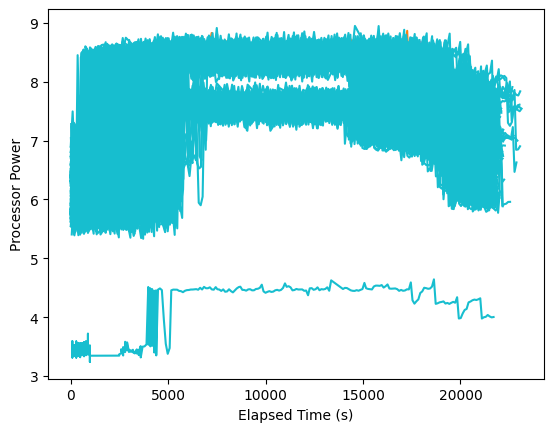

In [513]:
if(exp_name == "measuring_instrument"):
    key_index = 17
    keys = []
    for key in time_series:
        keys.append(key)
    RAPL_keys = [s for s in keys if "rapl" in s]
    # print(keys)
    print(keys[key_index])

    for i in range(len(time_series[keys[key_index]])):
        first = time_series[keys[key_index]][i] #Get the for timeSeries of the first key
        # print(first.shape)
        xAxis = first['ElapsedTime'].tolist()
        # print(keys)
        yAxis = first[GetMapping(keys[key_index])].tolist()

        # Create a scatter plot
        # plot.scatter(xAxis, yAxis, c=[plot.cm.tab10(i)])

        # Create a line plot
        plot.plot(xAxis, yAxis, c=plot.cm.tab10(i))

        # Add labels to the axes
    plot.xlabel('Elapsed Time (s)')
    plot.ylabel('Processor Power')

    # Show the plot
    plot.show()


In [514]:
for key in RAPL_keys:
    print(key)
    print(len(time_series[key]))

fannkuch-redux.exe.rapl.workstationtwo.all.intel-one-api.unix
462
idle-case.exe.rapl.workstationtwo.all.intel-one-api.unix
460
mandelbrot.exe.rapl.workstationtwo.all.intel-one-api.unix
460


In [515]:
import pandas as pd

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd



def create_smoothed_timeseries(timeseries, window_size):
    if window_size > len(timeseries):
        return timeseries
    num_windows = len(timeseries) - window_size + 1
    smoothed_series = np.zeros(num_windows)
    for i in range(num_windows):
        smoothed_series[i] = np.mean(timeseries[i:i+window_size])
    return smoothed_series

def RemoveOutliers(ts_list):
    # Exclude empty lists
    ts_list_cleaned = [ts for ts in ts_list if len(ts) > 0]

    df = pd.DataFrame([sum(x) for x in ts_list_cleaned], columns=["sum"])
    # Find outliers
    q1, q3 = np.percentile(df["sum"], [25, 75])
    iqr = q3 - q1
    outliers = df[(df["sum"] < q1 - 1.5 * iqr) | (df["sum"] > q3 + 1.5 * iqr)]["sum"].tolist()

    # Remove outliers from the original time series list
    ts_list_cleaned = [ts_list_cleaned[i] for i in range(len(ts_list_cleaned)) if sum(ts_list_cleaned[i]) not in outliers]

    return ts_list_cleaned


def AverageTimeseries(ts_list):
    avg_ts_dict = {}
    avg_ts = []
    ts_list = RemoveOutliers(ts_list)
    for ts in ts_list:
        for index in range(len(ts)):
            if(index in avg_ts_dict.keys()):
               avg_ts_dict[index] = [avg_ts_dict[index][0] + ts[index], avg_ts_dict[index][1] + 1]
            else:
               avg_ts_dict[index] = []
               avg_ts_dict[index] = [ts[index], 1]

    for key in avg_ts_dict.keys():
        avg_ts.append(avg_ts_dict[key][0]/avg_ts_dict[key][1])
    return avg_ts

import numpy as np


def TimeAwarePadding(time, values):
    # Flatten the input arrays
    time_flat = [t for sublist in time for t in sublist]
    values_flat = [v for sublist in values for v in sublist]
    
    # Find the minimum and maximum times across all lists
    min_time = np.min(time_flat)
    max_time = np.max(time_flat)
    
    # Create a new time array with a fixed time step
    new_time = np.arange(min_time, max_time + 1)
    
    # Create a new list with the padded time series data
    new_lst = np.empty_like(new_time)
    
    # Find the indices of the times in the original list that correspond to the new times
    idx = np.searchsorted(time_flat, new_time)
    
    # Pad the beginning and end of the new list with the first and last values in the original list
    new_lst[:idx[0]] = values_flat[0]
    new_lst[idx[-1]:] = values_flat[-1]
    
    # Interpolate the values for the remaining time points
    for i in range(len(idx) - 1):
        start = idx[i]
        end = idx[i+1]
        if start == end:
            continue
        new_lst[start:end] = np.interp(new_time[start:end], time_flat[start:end], values_flat[start:end])
    
    # Reshape the new list to match the original input lists
    output = []
    for i in range(len(time)):
        start = sum([len(lst) for lst in time[:i]])
        end = start + len(time[i])
        output.append(new_lst[start:end])
    
    return output



In [516]:
def CreateHeatData():
    heat_data = {}
    for key in keys:
        heat_data[key] = {}
        # test1 = TimeAwarePadding([x['ElapsedTime'].tolist() for x in time_series[key]],[x[GetMapping(key)].tolist() for x in time_series[key]])
        test = AverageTimeseries([x[GetMapping(key)].tolist() for x in time_series[key]])
        # test = AverageTimeseries([x for x in test1])
        heat_data[key] = test
    return heat_data

def interpolate(numbers, length):
    if len(numbers) >= length:
        return numbers[:length]

    new_numbers = []
    for i in range(length):
        index = i / (length - 1) * (len(numbers) - 1)
        left_index = int(index)
        right_index = left_index + 1
        if right_index >= len(numbers):
            new_numbers.append(numbers[-1])
        else:
            left_weight = right_index - index
            right_weight = index - left_index
            new_numbers.append(numbers[left_index] * left_weight + numbers[right_index] * right_weight)

    return new_numbers

def AdjustHeatDict(keys):
    for i in range(len(keys)):
        ex_ts = heat_data[keys[i]]
        idle_ts = heat_data[Idle_keys[i]]
        half_len = len(idle_ts) // 2
        adjusted_ts = idle_ts[:half_len] + ex_ts + idle_ts[half_len:]
        heat_data[keys[i]] = adjusted_ts

['idle-case.exe.ipg.workstationtwo.all.intel-one-api.win32nt', 'idle-case.exe.plug.workstationtwo.all.intel-one-api.win32nt', 'idle-case.exe.lhm.workstationtwo.all.intel-one-api.win32nt', 'idle-case.exe.scaphandre.workstationtwo.all.intel-one-api.win32nt', 'idle-case.exe.scaphandre_isolated.workstationtwo.all.intel-one-api.win32nt', 'idle-case.exe.clamp.workstationtwo.all.intel-one-api.win32nt', 'idle-case.exe.rapl.workstationtwo.all.intel-one-api.unix', 'idle-case.exe.plug.workstationtwo.all.intel-one-api.unix', 'idle-case.exe.clamp.workstationtwo.all.intel-one-api.unix']


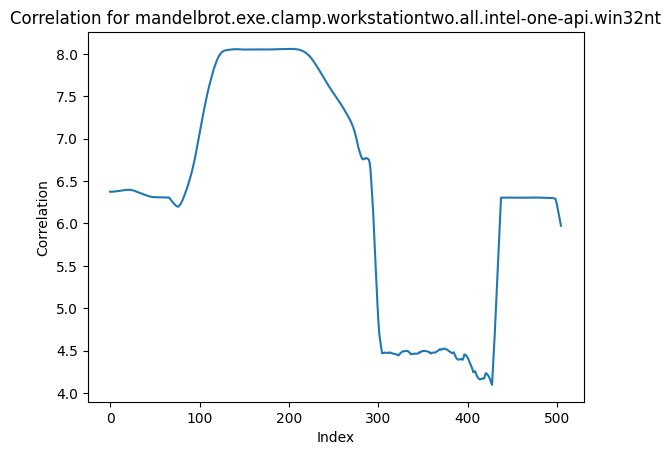

In [517]:
Mandel_keys = [s for s in keys if "mandelbrot" in s]
Fann_keys = [s for s in keys if "fannkuch" in s]
Idle_keys = [s for s in keys if "idle" in s]
print(Idle_keys)
heat_data = CreateHeatData()
AdjustHeatDict(Mandel_keys)
AdjustHeatDict(Fann_keys)

maax = max([len(heat_data[n]) for n in keys])
for n in keys:
    # heat_data[n] = interpolate(heat_data[n],maax)
    heatDate = interpolate(heat_data[n],maax)
    heat_data[n] =  create_smoothed_timeseries(heatDate,10)


if(exp_name == "measuring_instrument"):
    selectKey = Mandel_keys
    data = {}
    for Key1 in selectKey:
        data[Key1] = []
        if 'ipg' in Key1:
            heat_data[Key1] = [x/1000 for x in heat_data[Key1]]
        for Key2 in selectKey:
            corr = pd.Series(heat_data[Key1]).corr(pd.Series(heat_data[Key2]), method='kendall')
            data[Key1].append(corr)

    # Example of how to plot the first set of data
    index = 5

    plt.plot(heat_data[selectKey[index]])
    plt.title('Correlation for ' + selectKey[index])
    plt.xlabel('Index')
    plt.ylabel('Correlation')
    plt.show()

In [518]:
rows = [d.split(".")[2] for d in selectKey]
print(rows)
print(data)

['ipg', 'plug', 'lhm', 'scaphandre', 'scaphandre_isolated', 'clamp', 'rapl', 'plug', 'clamp']
{'mandelbrot.exe.ipg.workstationtwo.all.intel-one-api.win32nt': [1.0, 0.7064749332076065, 0.8688354549740689, 0.6627377023416627, 0.6505882289160536, 0.4006129184347006, 0.6182932578972183, 0.704038975326104, 0.703064592173503], 'mandelbrot.exe.plug.workstationtwo.all.intel-one-api.win32nt': [0.7064749332076065, 1.0, 0.7697469746974698, 0.6516265912305516, 0.6819152152203491, 0.4526795536696527, 0.6246581801037246, 0.7402954581172403, 0.7904290429042905], 'mandelbrot.exe.lhm.workstationtwo.all.intel-one-api.win32nt': [0.8688354549740689, 0.7697469746974698, 1.0, 0.6962124783906962, 0.680636562718133, 0.4063020587773063, 0.6181675310388182, 0.7554612604117554, 0.7405311959767406], 'mandelbrot.exe.scaphandre.workstationtwo.all.intel-one-api.win32nt': [0.6627377023416627, 0.6516265912305516, 0.6962124783906962, 1.0, 0.8227145272913041, 0.4555869872701556, 0.7045104510451045, 0.8146471790036146, 0

In [519]:
def Renamer(names):
    for key in names.keys():
        if(names[key] == "scaphandre"):
            names[key] = "SCAP"
        if(names[key] == "scaphandre_isolated"):
            names[key] = "SCAPI"
        if(names[key] == "ipg"):
            names[key] = "IPG"
        if(names[key] == "plug"):
            names[key] = "Plug"
        if(names[key] == "lhm"):
            names[key] = "LHM"
        if(names[key] == "clamp"):
            names[key] = "Clamp"
        if(names[key] == "rapl"):
            names[key] = "RAPL"
    return names

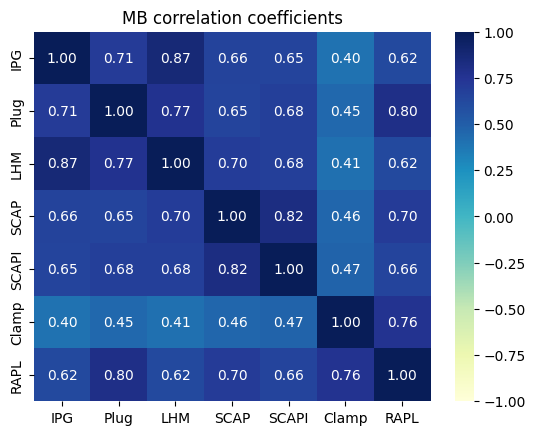

In [520]:
import seaborn as sns
import matplotlib.pyplot as plt

# create a dataframe using the data
df = pd.DataFrame.from_dict(data, orient='index', columns=rows)
# Create a dictionary that maps the old names to the new names
new_row = {old_name: old_name.split(".")[2] for old_name in df.index}
new_colume = {old_name: old_name for old_name in df.columns}

new_row = Renamer(new_row)
new_colume = Renamer(new_colume)
# Rename the rows using the dictionary
df.rename(index=new_row, inplace=True)
df.rename(columns=new_colume, inplace=True)

droped = df.iloc[[0,1,2,3,4,5,6], [0,1,2,3,4,5,6]]
droped.iloc[6,1] = df.iloc[6,7]
droped.iloc[6,5] = df.iloc[6,8]
droped.iloc[1,6] = df.iloc[6,7]
droped.iloc[5,6] = df.iloc[6,8]

# droped.iloc[6,1] = df.iloc[6,7]
# droped.iloc[6,5] = df.iloc[6,8]

# create a heatmap
sns.heatmap(droped, cmap="YlGnBu", annot=True, fmt='.2f', vmin=-1, vmax=1)

# set the title of the plot
# plt.title(selectKey[0].split(".")[0].capitalize() + " correlation coefficients")
plt.title("MB correlation coefficients")

plt.savefig(f'C:\\Users\\Jeppe\\Downloads\\{selectKey[0].split(".")[0].capitalize()}.png', transparent=True)

# display the plot
plt.show()


In [521]:
print(df)

            IPG      Plug       LHM      SCAP     SCAPI     Clamp      RAPL  \
IPG    1.000000  0.706475  0.868835  0.662738  0.650588  0.400613  0.618293   
Plug   0.706475  1.000000  0.769747  0.651627  0.681915  0.452680  0.624658   
LHM    0.868835  0.769747  1.000000  0.696212  0.680637  0.406302  0.618168   
SCAP   0.662738  0.651627  0.696212  1.000000  0.822715  0.455587  0.704510   
SCAPI  0.650588  0.681915  0.680637  0.822715  1.000000  0.470183  0.655637   
Clamp  0.400613  0.452680  0.406302  0.455587  0.470183  1.000000  0.387412   
RAPL   0.618293  0.624658  0.618168  0.704510  0.655637  0.387412  1.000000   
Plug   0.704039  0.740295  0.755461  0.814647  0.715865  0.450024  0.799686   
Clamp  0.703065  0.790429  0.740531  0.737702  0.719308  0.507795  0.761590   

           Plug     Clamp  
IPG    0.704039  0.703065  
Plug   0.740295  0.790429  
LHM    0.755461  0.740531  
SCAP   0.814647  0.737702  
SCAPI  0.715865  0.719308  
Clamp  0.450024  0.507795  
RAPL   0.7996

In [522]:
if(exp_name == "compiler"):
    print(keys)
    testCase_dict = {}
    for key in keys:
        for testCase in used_test_case_names:
            # print("test case: "+ testCase)
            if testCase in key:
                if testCase in testCase_dict:
                    testCase_dict[testCase].append(key)
                else:
                    testCase_dict[testCase] = [key]
    print(testCase_dict)

In [523]:
import pandas as pd
import seaborn as sns

if(exp_name == "compiler"):
    testCase_keys = list(testCase_dict.keys())
    testCase_Index = 0
    Heat_dict ={}
    for compiler_Key in testCase_keys: #Get Each compiler from a specific test case
        compilerK = testCase_dict[compiler_Key]
        data_dict = {}  # create an empty dictionary to store the time series data
        for com in compilerK:
            for i in range(len(time_series[com])):
                key = f"{com}_{i}"  # create a unique key for each time series
                data = time_series[com][i]
                data_dict[key] = pd.DataFrame(data)  # add the time series data to the dictionary
                xAxis = data['ElapsedTime'].tolist()
                yAxis = data["ProcessorPowerInWatt"].tolist()
                plot.plot(xAxis, yAxis, c=plot.cm.tab10(i))

        # Add labels to the axes
        plot.xlabel('Elapsed Time (s)')
        plot.ylabel('Processor Power')
        # Show the plot
        plot.show()


In [524]:
import pandas as pd
import seaborn as sns

if(exp_name == "compiler"):
    testCase_keys = list(testCase_dict.keys())
    testCase_Index = 0
    Heat_dict ={}
    for compiler_Key in testCase_keys: #Get Each compiler from a specific test case
        compilerK = testCase_dict[compiler_Key]
        Heat_dict[compiler_Key] = {}  # create an empty dictionary to store the time series data
        for com in compilerK:
            for i in range(len(time_series[com])):
                key = f"{com}.{i}"  # create a unique key for each time series
                data = time_series[com][i]
                Heat_dict[compiler_Key][key] = data["ProcessorPowerInWatt"].tolist()


In [525]:
import pandas as pd
if(exp_name == "compiler"):
    data = {}
    for compiler_Key in testCase_keys:
        data[compiler_Key] = []
        for case1 in Heat_dict[compiler_Key].keys():
            data[compiler_Key].append([])
            for case2 in Heat_dict[compiler_Key].keys():
                corr = pd.Series(Heat_dict[compiler_Key][case1]).corr(pd.Series(Heat_dict[compiler_Key][case2]), method='kendall')
                data[compiler_Key][-1].append(corr)


In [526]:
import seaborn as sns
import matplotlib.pyplot as plt
if(exp_name == "compiler"):
    for compiler_Key in testCase_keys:
        # create a 2D array with some data
        # create a heatmap using Seaborn
        xAxis = [f"{x.split('.')[5]}{x.split('.')[7]}" for x in list(Heat_dict[compiler_Key].keys())]
        print(xAxis)
        sns.heatmap(data[compiler_Key], annot=True, fmt=".2f", cmap="YlGnBu", linewidths=.5, cbar_kws={"shrink": .5}, 
                    xticklabels=xAxis, 
                    yticklabels=xAxis, 
                    annot_kws={"size": 7},
                    square=True)

        sns.set(rc={'figure.figsize':(40,40)})


        # add labels and title to the plot
        plt.xlabel("Columns", fontsize=16)
        plt.ylabel("Rows", fontsize=16)
        plt.title(compiler_Key, fontsize=18)

        # display the plot
        plt.show()